<a href="https://colab.research.google.com/github/SubhashKrYadav/FloraNet-Deep-Learning-Flower-Prediction-Model/blob/main/flower_recognition_deep_learning_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install jovian --upgrade --quiet

## TODO

1. Pick a dataset
2. Download the dataset
3. Import the dataset using PyTorch
4. Explore the dataset
5. Prepare the dataset for training

### Download the Dataset

Using `opendatasets` and download the datasat from https://www.kaggle.com/alxmamaev/flowers-recognition .

In [3]:
!pip install opendatasets --upgrade --quiet

In [5]:
import opendatasets as od

In [6]:
dataset_url = 'https://www.kaggle.com/alxmamaev/flowers-recognition'

In [7]:
import os
import shutil

if os.path.exists('./flowers-recognition'):
    shutil.rmtree('./flowers-recognition')

In [8]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: subhashkumaryadav
Your Kaggle Key: ··········


100%|██████████| 225M/225M [00:01<00:00, 144MB/s]


In [9]:
data_dir = './flowers-recognition/flowers'

In [10]:
import os

In [11]:
os.listdir(data_dir)

['tulip', 'dandelion', 'sunflower', 'daisy', 'rose']

In [14]:
for cls in os.listdir(data_dir):
    print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

tulip : 984
dandelion : 1052
sunflower : 733
daisy : 764
rose : 784


In [15]:
!pip install jovian --quiet

In [16]:
import jovian

In [17]:
jovian.commit(project='flower-recognition-deep-learning-model')

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


### Import the Dataset Into PyTorch

Use the `ImageFolder` class from `torchvision`.



In [18]:
from torchvision.datasets import ImageFolder

In [19]:
dataset = ImageFolder(data_dir)

In [20]:
len(dataset)

4317

In [21]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=320x263>, 0)

In [22]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

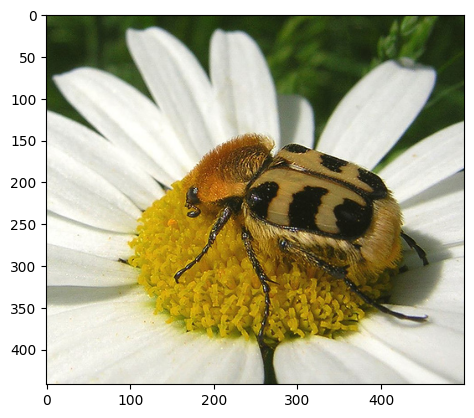

In [24]:
img, label = dataset[120]
plt.imshow(img)

In [25]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64),
                                            tt.RandomCrop(64),
                                            tt.ToTensor()]))

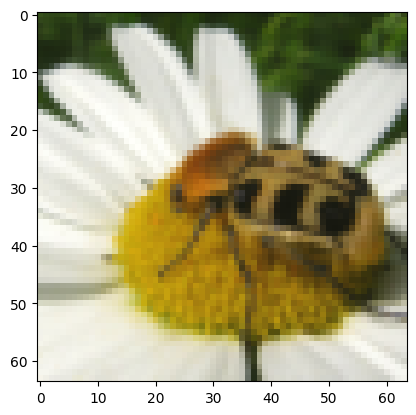

In [26]:
img, label = dataset[120]
plt.imshow(img.permute((1, 2, 0)))

In [28]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(3886, 431)

In [29]:
from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(3886, 431)

In [30]:
from torch.utils.data import DataLoader

batch_size = 128

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)

valid_dl = DataLoader(valid_ds,
                    batch_size,
                    num_workers=4,
                    pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [31]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

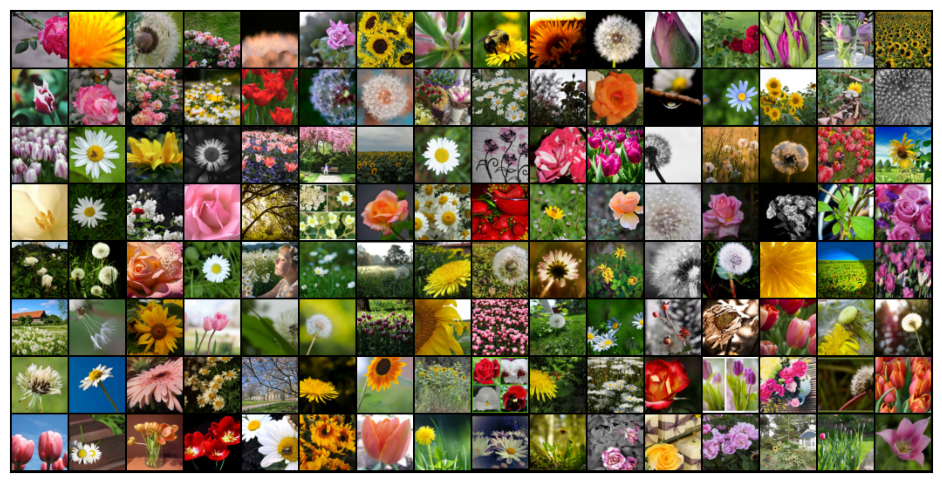

In [32]:
show_batch(train_dl)

### GPU Utilities

In [33]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [34]:
torch.cuda.is_available()

True

In [35]:
device = get_default_device()

In [36]:
device

device(type='cuda')

In [37]:
img, label = dataset[0]

In [38]:
img.device

device(type='cpu')

In [39]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [40]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model and Training Utilties

In [41]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [42]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluates the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Model

In [43]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32

        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [44]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [45]:
model.conv1[0].weight.device

device(type='cuda', index=0)

Pass one batch of input tensor through the model.

In [47]:
jovian.commit(project='flower-recognition-deep-learning-model')

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


In [48]:
torch.cuda.empty_cache()
for batch in train_dl:
    images, labels = batch
    print('images.shape', images.shape)
    print('images.device', images.device)
    preds = model(images)
    print('preds.shape', preds.shape)
    break

images.shape torch.Size([128, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([128, 5])


### Training

In [49]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.608884572982788, 'val_acc': 0.20358210802078247}]

In [50]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.5214, val_loss: 1.6278, val_acc: 0.3406
Epoch [1], train_loss: 1.0127, val_loss: 0.9447, val_acc: 0.6271
Epoch [2], train_loss: 0.9202, val_loss: 0.9014, val_acc: 0.6839
Epoch [3], train_loss: 0.7980, val_loss: 0.9061, val_acc: 0.6587
Epoch [4], train_loss: 0.7251, val_loss: 0.9321, val_acc: 0.6708


In [51]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.8468, val_loss: 0.7724, val_acc: 0.6951
Epoch [1], train_loss: 0.6781, val_loss: 0.8532, val_acc: 0.6945
Epoch [2], train_loss: 0.6471, val_loss: 0.8342, val_acc: 0.7419
Epoch [3], train_loss: 0.5572, val_loss: 1.0639, val_acc: 0.6557
Epoch [4], train_loss: 0.5061, val_loss: 1.3898, val_acc: 0.5474


In [52]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.3967, val_loss: 0.4747, val_acc: 0.8378
Epoch [1], train_loss: 0.3396, val_loss: 0.4906, val_acc: 0.8241
Epoch [2], train_loss: 0.3493, val_loss: 0.4996, val_acc: 0.8202
Epoch [3], train_loss: 0.3199, val_loss: 0.4803, val_acc: 0.8266
Epoch [4], train_loss: 0.2973, val_loss: 0.4684, val_acc: 0.8241


In [53]:
history += fit(5, 0.0001, model, train_dl, valid_dl)

Epoch [0], train_loss: 0.2850, val_loss: 0.4755, val_acc: 0.8339
Epoch [1], train_loss: 0.2839, val_loss: 0.4858, val_acc: 0.8255
Epoch [2], train_loss: 0.2777, val_loss: 0.4607, val_acc: 0.8411
Epoch [3], train_loss: 0.2755, val_loss: 0.4575, val_acc: 0.8411
Epoch [4], train_loss: 0.2734, val_loss: 0.4552, val_acc: 0.8333


In [54]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

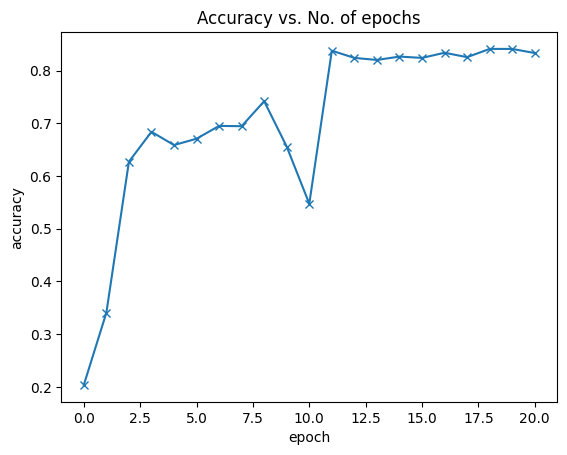

In [55]:
plot_accuracies(history)

In [56]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

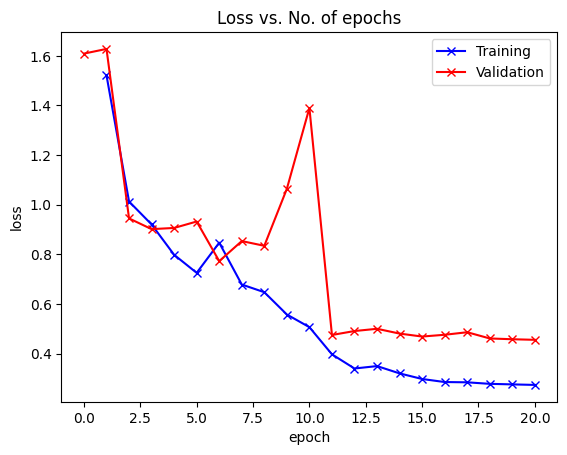

In [57]:
plot_losses(history)

### Record the Results

In [58]:
history[-1]

{'val_loss': 0.4551588296890259,
 'val_acc': 0.8333194851875305,
 'train_loss': 0.273377388715744}

In [59]:
jovian.reset()
jovian.log_dataset(image_size=64)
jovian.log_hyperparams(batch_size=128,
                       arch='ResNet9',
                       epochs=[5, 5, 5, 5],
                       lrs=[0.001, 0.001, 1e-4, 1e-4],
                       opt=['Adam', 'Adam', 'Adam', 'SGD'])
jovian.log_metrics(train_loss=history[-1]['train_loss'],
                   val_acc=history[-1]['val_acc'],
                   val_loss=history[-1]['val_loss'])

[jovian] Please enter your API key ( from https://jovian.com/ ):
API KEY: ··········
[jovian] Dataset logged.
[jovian] Hyperparams logged.
[jovian] Metrics logged.


In [60]:
jovian.commit(project='flower-recognition-deep-learning-model')

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


### Test with Individual Images

In [61]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [62]:
def show_image_prediction(img, label):
    plt.imshow(img.permute((1, 2, 0)))
    pred = predict_image(img, model, dataset.classes)
    print('Target:', dataset.classes[label])
    print('Prediction:', pred)

Target: tulip
Prediction: tulip


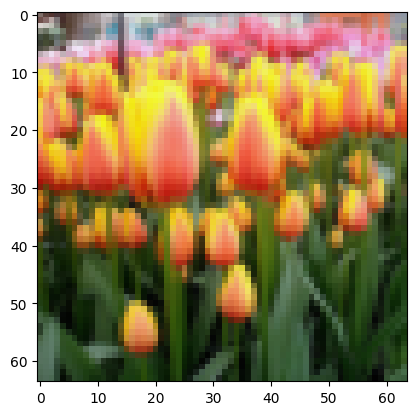

In [63]:
show_image_prediction(*valid_ds[100])

Target: daisy
Prediction: tulip


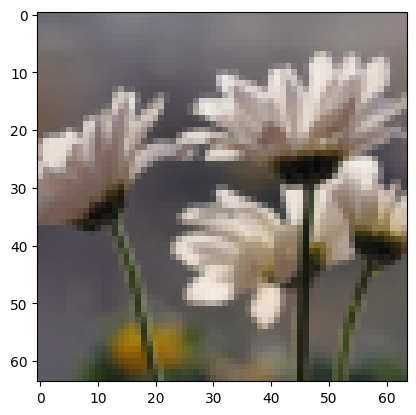

In [64]:
show_image_prediction(*valid_ds[300])

Target: dandelion
Prediction: dandelion


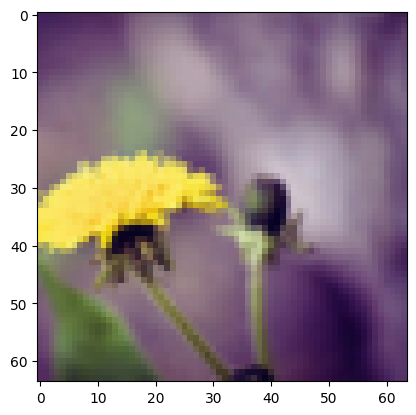

In [65]:
show_image_prediction(*valid_ds[12])

In [66]:
torch.save(model.state_dict(), 'flowers-resnet9.pth')